In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import yfinance as yf
import sys
import numpy_financial as npf

# Typical range of drift and volatility

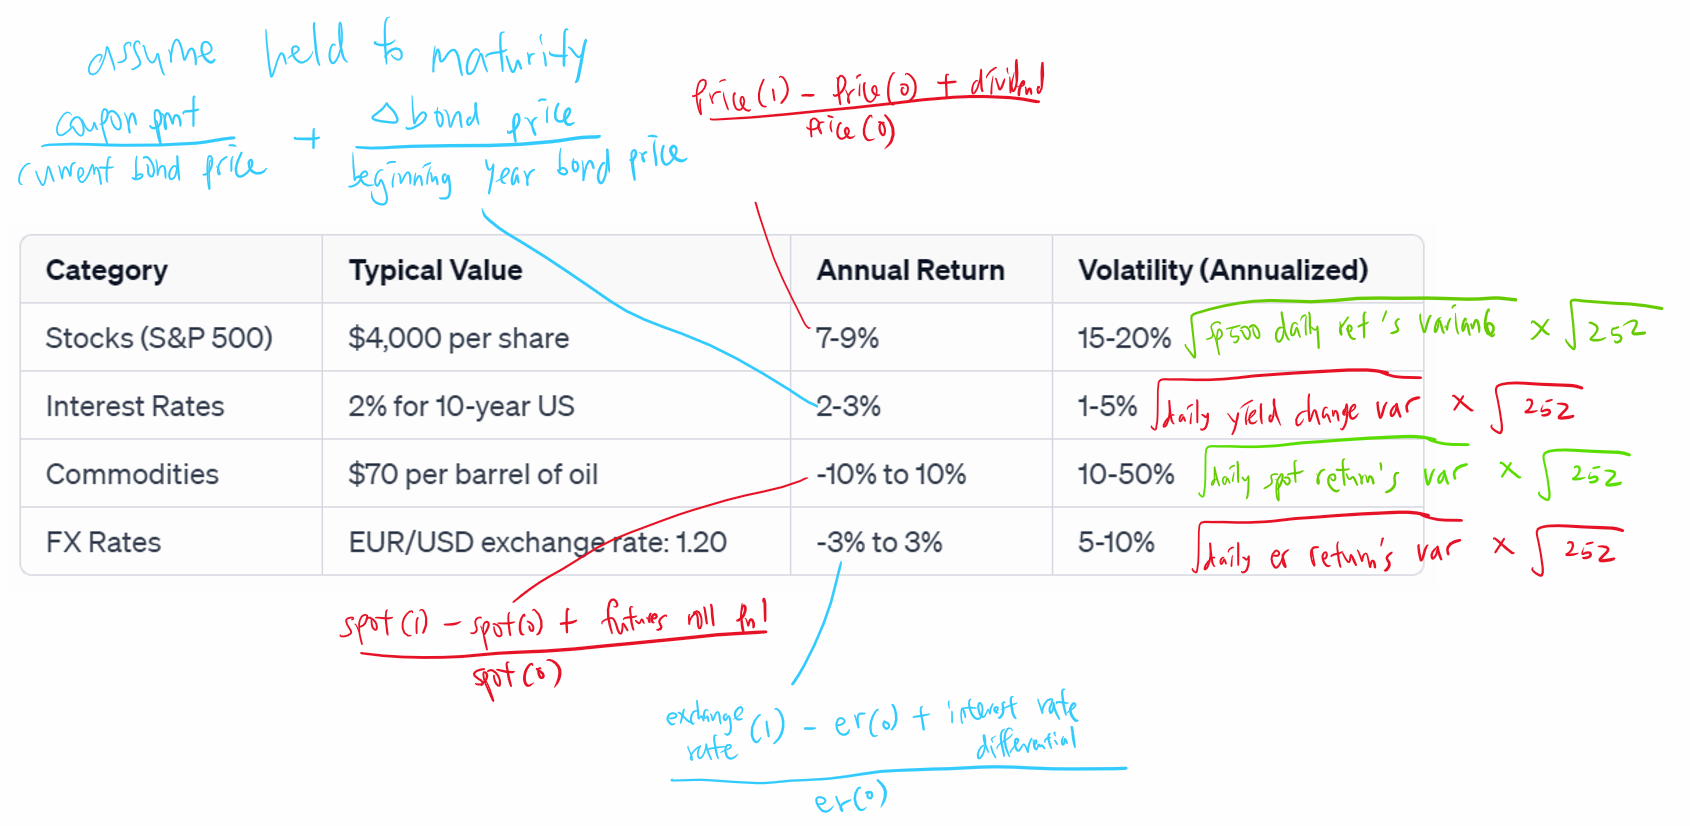

<a id='eachpnl'></a>
# How to calc pnl of diff assets
- standardised to use 365 days a year 

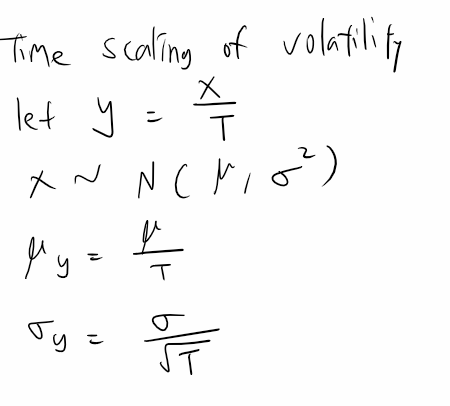

<a id='ir'></a>
# Synthetic bond 
- assume never net short to avoid calculating borrowing cost

### Interest rate models
- Vasicek Model:
    - earliest interest rate models.
    - It's a one-factor model that describes the evolution of interest rates using a mean-reverting stochastic differential equation.
    - assumes that interest rates can become negative, which can be a limitation.

- Cox-Ingersoll-Ross (CIR) Model:
    - an extension of the Vasicek model that ensures that interest rates stay positive.
    
- Hull-White Model:
    - An extension of CIR models
    - It can calibrate to the current term structure of interest rates and accommodate a variety of shapes of the yield curve.
    - The model incorporates time-dependent parameters to fit the term structure of interest rates more accurately.

- Libor Market Model (LMM):
    - Also known as the BGM Model (Brace-Gatarek-Musiela Model).
    - It models the dynamics of the forward LIBOR rates rather than the instantaneous short rate.
    - The LMM is particularly popular for pricing interest rate derivatives like caps, floors, and swaptions.

- Heath-Jarrow-Morton (HJM) Framework:
    - modeling forward interest rates that directly specifies the dynamics of the entire yield curve.
    - Unlike other models that typically describe the short rate, the HJM framework models the drift and volatility of the forward rates. It's quite general and can be used to derive many other interest rate models.

- Black-Derman-Toy (BDT) Model:
    - A one-factor model for the evolution of forward rates.Known for its ability to fit the term structure of interest rates and its use in the valuation of bond options.

### Cox-Ingersoll-Ross (CIR) Model
stochastic differential equation
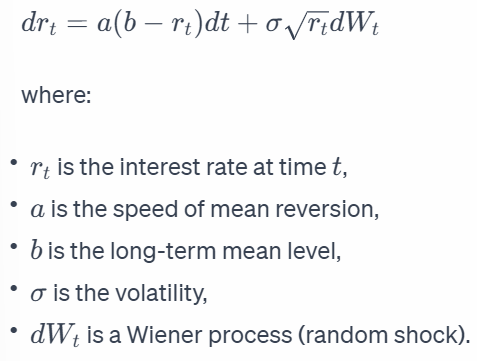

In [2]:
def simulate_cir(r0, a, b, sigma, T, N, seed=None):
    """
    Simulate interest rate path using the Cox-Ingersoll-Ross (CIR) model.

    Parameters:
    r0 (float): The initial interest rate.
    a (float): Speed of mean reversion.
    b (float): Long-term mean level.
    sigma (float): Volatility.
    T (float): Time horizon.
    N (int): Number of steps.
    seed (int, optional): Seed for the random number generator.

    Returns:
    numpy.ndarray: Array of simulated interest rates.
    """
    np.random.seed(seed)

    dt = T / N  # Time step
    rates = np.zeros(N)
    rates[0] = r0

    for i in range(1, N):
        
        dr = (
            a * (b - rates[i-1]) * dt 
            + sigma * np.sqrt(rates[i-1]) * np.sqrt(dt) * np.random.normal()
             )
        
        rates[i] = rates[i-1] + dr

    return rates


def bond_price(coupon_rate, face_value, current_rate, years_to_maturity, frequency=2):
    """
    Calculate the price of a bond based on the current interest rate.

    Parameters:
    coupon_rate (float): Annual coupon rate as a decimal.
    face_value (float): The face value of the bond.
    current_rate (float): Current annual interest rate as a decimal.
    years_to_maturity (float): Years until the bond matures.
    frequency (int): Number of coupon payments per year.

    Returns:
    float: The price of the bond.
    """
    coupon_payment = coupon_rate * face_value / frequency
    periods = years_to_maturity * frequency
    bond_price = npf.pv(rate=current_rate/frequency, nper=periods, pmt=-coupon_payment, fv=-face_value)
    return bond_price

def calculate_daily_pnl(interest_rates, coupon_rate, face_value, maturity_years, frequency=2):
    """
    Calculate the daily PnL of holding a bond, given a path of interest rates.

    Parameters:
    interest_rates (numpy.ndarray): Array of simulated interest rates.
    coupon_rate (float): Annual coupon rate as a decimal.
    face_value (float): The face value of the bond.
    maturity_years (float): Original maturity in years of the bond.
    frequency (int): Number of coupon payments per year.

    Returns:
    numpy.ndarray: Array of daily PnL.
    """
    pnl = np.zeros(len(interest_rates))
    bond_prices = np.array([bond_price(coupon_rate, face_value, rate, maturity_years - i / (frequency * 365), frequency)
                            for i, rate in enumerate(interest_rates)])
    
    for i in range(1, len(interest_rates)):
        capital_gain = bond_prices[i] - bond_prices[i-1]
        coupon_payment = coupon_rate * face_value / frequency if i % (365//frequency) == 0 else 0
        pnl[i] = capital_gain + coupon_payment

    return pnl

In [3]:
r0 = 0.03      # Initial interest rate (3%)
a = 0.1        # Speed of mean reversion
b = 0.05       # Long-term mean level
sigma = 0.02   # Volatility
T = 1          # Time horizon (1 year)
N = 365        # Number of steps (e.g., trading days in a year)
seed = 0      # Random seed

interest_rates = simulate_cir(r0, a, b, sigma, T, N, seed)

In [4]:
# for verification purpose only

# # to verify that a t-bond issued at interest rate of x% will have a semi-annual coupon of x/2% 
# # note that coupon rate is typically quoted at annual basis

# def run():
#     coupon_rates = []
#     n_periods = 20 # total number of coupon payment = 2 semi-annual * 10 years t-bonds = 20
#     notional_value = 1000

#     for rate in interest_rates:
#         coupon_payment = npf.pmt(rate / 2, n_periods, -notional_value, notional_value)
#         coupon_rate = coupon_payment * 2 / notional_value
#         coupon_rates.append(coupon_rate)

#     return np.array(coupon_rates)

# coupon_rates = run()

# pd.DataFrame({'interest_rates': interest_rates, 'coupon_rates': coupon_rates}).plot()

In [5]:
# Synthetic bond trades

def run():
    np.random.seed(0)
    length = 365
    random_values = np.random.rand(length)
    bond_trades = np.zeros(length)
    cum_pos = np.zeros(length)  # Initialize the cumulative position array

    for i, val in enumerate(random_values):
        if val < 0.05:  # 5% chance of positive trade
            magnitude = np.random.choice([3e6, 2e6, 1e6], p=[0.1, 0.2, 0.7])
            proposed_trade = magnitude
        elif val < 0.1:  # 5% chance of negative trade
            magnitude = np.random.choice([-3e6, -2e6, -1e6], p=[0.1, 0.2, 0.7])
            proposed_trade = magnitude
        else:
            proposed_trade = 0

        # Check if the proposed trade will make us net short
        if i == 0:
            cum_pos[i] = proposed_trade
        else:
            if cum_pos[i-1] + proposed_trade >= 0:
                cum_pos[i] = cum_pos[i-1] + proposed_trade
                bond_trades[i] = proposed_trade
            else:
                # Skip the trade to avoid going net short
                cum_pos[i] = cum_pos[i-1]

    return bond_trades, cum_pos

bond_trades, cum_pos = run()

# Calc daily bonds pnl
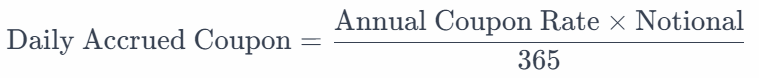
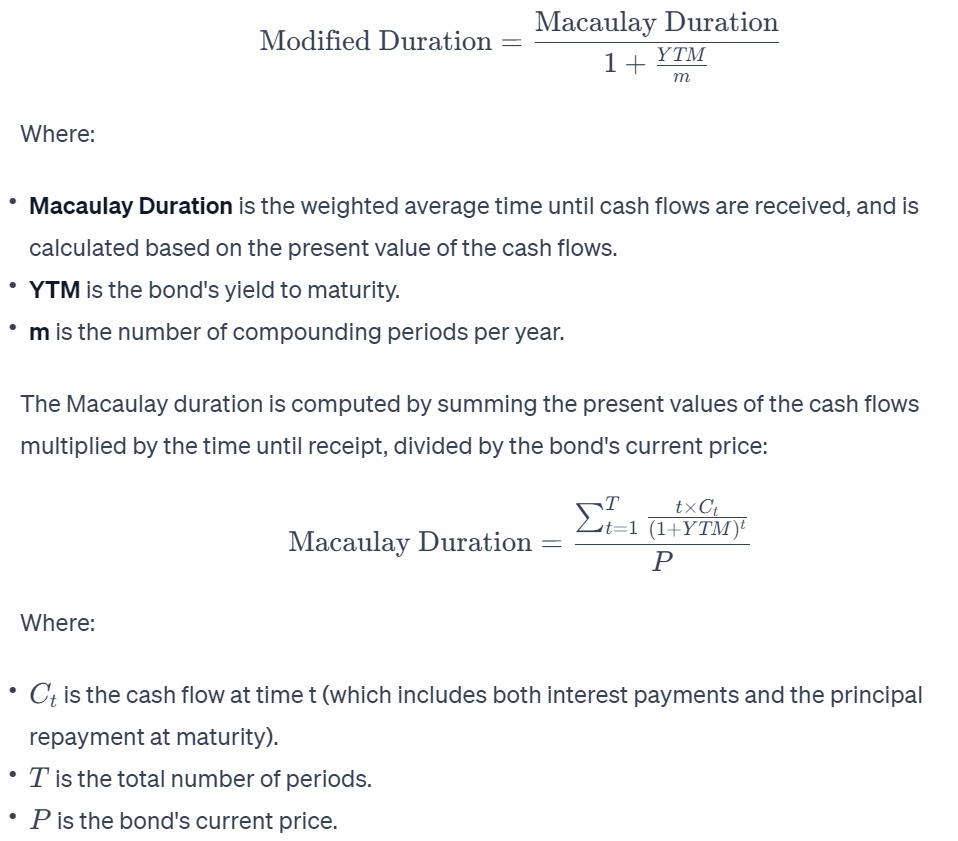

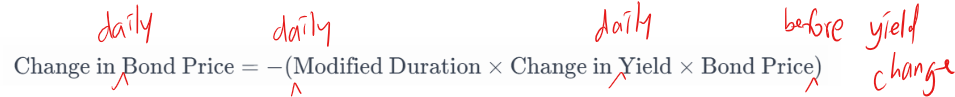

In [6]:
def calculate_durations(cash_flows, ytm, periods_per_year):
    # Calculate the time of each cash flow
    time_periods = np.arange(1, len(cash_flows) + 1)
    
    # Calculate the present value of each cash flow
    pv_cash_flows = cash_flows / (1 + ytm/periods_per_year) ** time_periods
    
    # Calculate Macaulay Duration
    macaulay_duration = np.sum(time_periods * pv_cash_flows) / np.sum(pv_cash_flows)
    
    # Calculate Modified Duration
    modified_duration = macaulay_duration / (1 + ytm/periods_per_year)
    
    return modified_duration

In [7]:
def run():
    # 1mil notional of treasury bond logically give around +/-$1000 pnl daily (daily pnl = daily accrued coupon + daily bond price change)

    bond_pnl = np.zeros(365)
    non_zero_indices = np.where(bond_trades != 0)[0]
    periods_per_year = 2

    for i in non_zero_indices:

        bond_price = bond_trades[i]
        face_value = bond_trades[i] 
        coupon_rate = interest_rates[i]
        coupon = coupon_rate * face_value / 365 
        maturity_years = 10

        bond_pnl[i] -= (face_value*0.0015)
        
        max1 = min(len(bond_pnl), i+3650)
            
        for j in range(i+1, max1):
            ytm = interest_rates[j]

            cash_flows = np.full(maturity_years * periods_per_year, (face_value * coupon_rate) / periods_per_year)
            cash_flows[-1] += face_value  

            mod_dur = calculate_durations(cash_flows, ytm, periods_per_year)

            capital_app = -(
                mod_dur/365 
                * (interest_rates[j]-interest_rates[j-1]) / 365 
                * bond_price
            )

            bond_pnl[j] += (coupon + capital_app)
            
            bond_price -= capital_app
            
            if j == (i+1) and i ==14:
                print('coupon_rate = ', coupon_rate)
                print('face_value = ', face_value)
                print(f'coupon = {coupon:.10f}')
                print('capital_app = ', capital_app)
                print('after = ', bond_pnl)
            
        if i+3650 < len(bond_pnl):
            bond_pnl[j] += face_value
            
    return bond_pnl
        
bond_pnl = run()

# Summary
- days of data: 365 days
- bond_pnl : array of bond portfolio pnl daily
- cum_pos : array of cumulative bond positions
- bond_trades : array of daily bond trades

<Axes: >

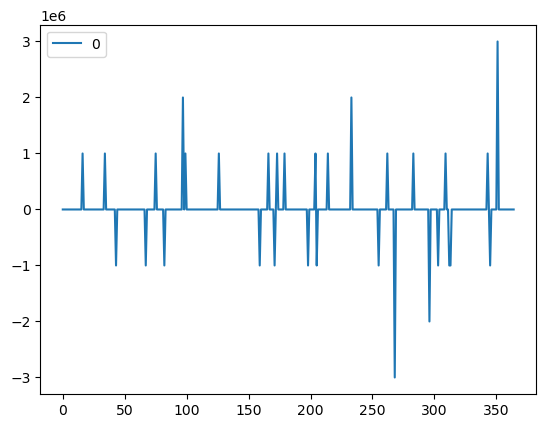

In [11]:
pd.DataFrame(bond_trades).plot()

<Axes: >

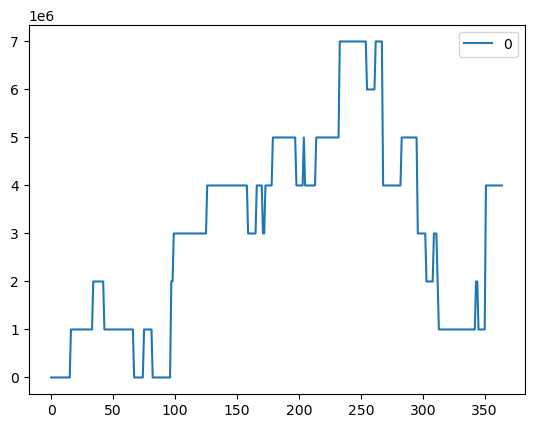

In [10]:
pd.DataFrame(cum_pos).plot()

<Axes: >

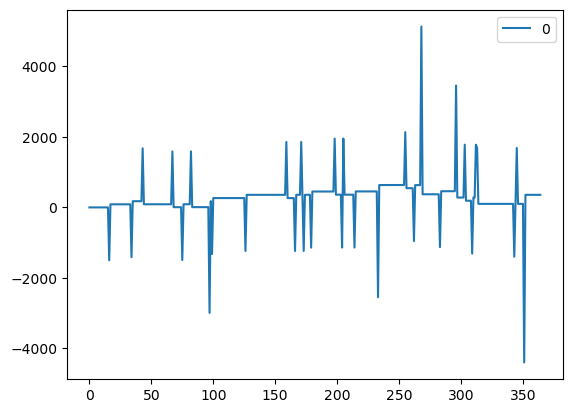

In [9]:
pd.DataFrame(bond_pnl).plot()